In [ ]:
pip install openet-core


In [ ]:
from datetime import datetime, timedelta
import os
import pprint

import ee
import openet.core
import pandas as pd

from IPython.display import Image, display
import ipyplot

ee.Initialize()

In [2]:
import ee
from IPython.display import Image

# import openet.core
import openet.core.common as common


In [3]:
from openet.core import __version__ as version
print(version)


0.4.2


In [4]:
ee.Authenticate()
ee.Initialize(project='openet')

In [5]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C',
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']

image_size = 768


In [18]:
xy = [-102.266679, 34.368470]
dx = 1.0
dy = 1.0
study_area = ee.Geometry.Rectangle(xy[0]-dx, xy[1]-dy, xy[0]+dx, xy[1]+dy)
study_region = study_area.bounds(1, 'EPSG:4326').coordinates().getInfo()

In [19]:
landsat_id = 'LANDSAT/LC08/C02/T1_L2/LC08_030036_20210725'
landsat_img = ee.Image(landsat_id)
true_color_img = landsat_img.select(['SR_B4', 'SR_B3', 'SR_B2']).multiply(0.0000275).add(-0.2)

# et_img = et_img.select('et')


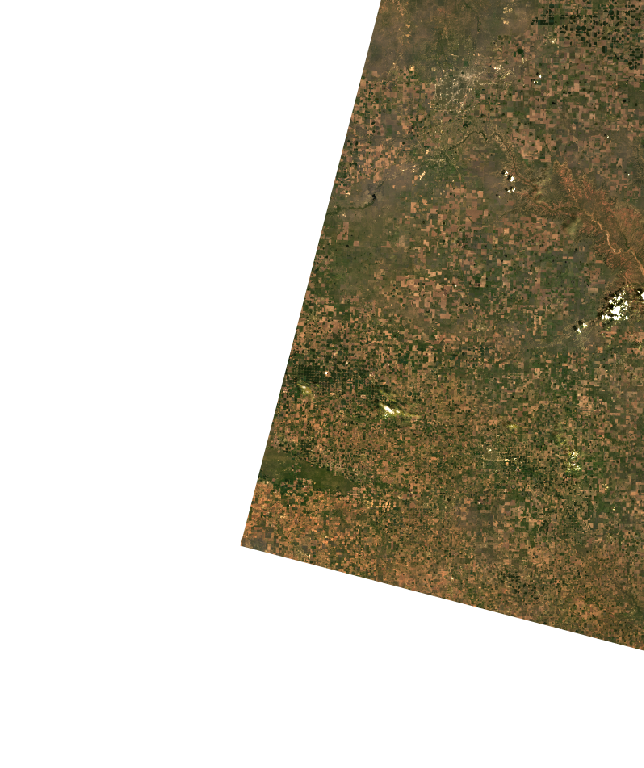

In [20]:
Image(url=true_color_img.getThumbURL({'min': 0.0, 'max': 0.3, 'region': study_region,
                                      'dimensions': image_size}), embed=True, format='png')


In [ ]:
ssebop_scene_coll_id = 'projects/openet/assets/ssebop/conus/gridmet/landsat/c02'
sims_scene_coll_id = 'projects/openet/assets/sims/conus/gridmet/landsat/c02'
ptjpl_scene_coll_id = 'projects/openet/assets/ptjpl/conus/gridmet/landsat/c02'
geesebal_scene_coll_id = 'projects/openet/assets/geesebal/conus/gridmet/landsat/c02'
eemetric_scene_coll_id = 'projects/openet/assets/eemetric/conus/gridmet/landsat/c02'
disalexi_scene_coll_id = 'projects/openet/assets/disalexi/landsat/c02'
ensemble_scene_coll_id = 'projects/openet/assets/ensemble/conus/gridmet/landsat/c02'

# The Ocean mask is True for water, so flip it for updateMask call so that land pixels are 1
land_mask = ee.Image('projects/openet/assets/features/water_mask').Not()
# Apply the NLCD/NALCMS water mask (anywhere it is water, set the ocean mask
land_mask = land_mask.where(ee.Image("USGS/NLCD_RELEASES/2020_REL/NALCMS").unmask(18).eq(18), 0)
# land_mask = land_mask.And(ee.Image("USGS/NLCD_RELEASES/2020_REL/NALCMS").unmask(18).neq(18))

# land_mask = ee.Image('projects/openet/assets/meteorology/conus404/ancillary/land_mask')

# image_size = 700
image_size = 1024

rgb_bands = {
    'LT05': ['SR_B3', 'SR_B2', 'SR_B1'],
    'LE07': ['SR_B3', 'SR_B2', 'SR_B1'],
    'LC08': ['SR_B4', 'SR_B3', 'SR_B2'],
    'LC09': ['SR_B4', 'SR_B3', 'SR_B2'],
}
et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C',
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A'
]


In [ ]:
def fmask(landsat_sr_img):
    # Extracting cloud masks from pixel_qa using rightShift() andbitwiseAnd()
    # EE automatically masks fill pixels?
    qa_img = landsat_sr_img.select('QA_PIXEL');
    fill_mask = qa_img.bitwiseAnd(1).neq(0)                  # bits: 0
    dilate_mask = qa_img.rightShift(1).bitwiseAnd(1).neq(0)  # bits: 1
    cirrus_mask = qa_img.rightShift(2).bitwiseAnd(1).neq(0)  # bits: 2
    cloud_mask = qa_img.rightShift(3).bitwiseAnd(1).neq(0)   # bits: 3
    shadow_mask = qa_img.rightShift(4).bitwiseAnd(1).neq(0)  # bits: 4
    snow_mask = qa_img.rightShift(5).bitwiseAnd(1).neq(0)    # bits: 5
    clear_mask = qa_img.rightShift(6).bitwiseAnd(1).neq(0)   # bits: 6
    water_mask = qa_img.rightShift(7).bitwiseAnd(1).neq(0)   # bits: 7
    # cloud_conf = qa_img.rightShift(8).bitwiseAnd(3)          # bits: 8, 9
    # shadow_conf = qa_img.rightShift(10).bitwiseAnd(3)        # bits: 10, 11
    # snow_conf = qa_img.rightShift(12).bitwiseAnd(3)          # bits: 12, 13
    # cirrus_conf = qa_img.rightShift(14).bitwiseAnd(3)        # bits: 14, 15

    # Old "Fmask" style image
    fmask_img = (
        fill_mask
        .where(water_mask, 5)
        .where(shadow_mask, 2)
        .where(snow_mask, 3)
        .where(cloud_mask.Or(dilate_mask).Or(cirrus_mask), 4)
    )

    return fmask_img.updateMask(fmask_img.neq(0)).rename(['fmask'])


In [ ]:
true_color_sr_bands = {
  'LT05': ['SR_B3', 'SR_B2', 'SR_B1'],
  'LE07': ['SR_B3', 'SR_B2', 'SR_B1'],
  'LC08': ['SR_B4', 'SR_B3', 'SR_B2'],
  'LC09': ['SR_B4', 'SR_B3', 'SR_B2'],
}
true_color_toa_bands = {
    'LT05': ['B3', 'B2', 'B1'],
    'LE07': ['B3', 'B2', 'B1'],
    'LC08': ['B4', 'B3', 'B2'],
    'LC09': ['B4', 'B3', 'B2'],
}


def image_stats(scene_id):
    # scene_id = ee.String(landsat_img.get('scene_id'))
    # landsat_type = scene_id.slice(0, 4)
    landsat_type = scene_id[0:4].upper()

    landsat_sr_img = ee.Image(f'LANDSAT/{landsat_type}/C02/T1_L2/{scene_id.upper()}')
    landast_toa_img = ee.Image(f'LANDSAT/{landsat_type}/C02/T1_TOA/{scene_id.upper()}')

    default_stats = ee.Dictionary({
        'UNMASKED_PIXELS': -1, 'TOTAL_PIXELS': -1,
        'CLOUD_PIXELS': -1, 'CIRRUS_PIXELS': -1, 'DILATE_PIXELS': -1,
        'SHADOW_PIXELS': -1, 'SNOW_PIXELS': -1, 'WATER_PIXELS': -1,
        'SR_RED': -1, 'SR_GREEN': -1, 'SR_BLUE': -1,
        'UNMASKED_SR_RED': -1, 'UNMASKED_SR_GREEN': -1, 'UNMASKED_SR_BLUE': -1,
        'TOA_RED': -1, 'TOA_GREEN': -1, 'TOA_BLUE': -1,
        'UNMASKED_TOA_RED': -1, 'UNMASKED_TOA_GREEN': -1, 'UNMASKED_TOA_BLUE': -1,
        'CLOUD_COVER_LAND': landsat_sr_img.get('CLOUD_COVER_LAND'),
        # 'SSEBOP_ETF_count': -9999,
        # 'SSEBOP_ETF_mean': -9999,
        'SCENE_ID': scene_id,
    })

    # # Simple Cloud Score (ACCA)
    # acca_mask = ee.Algorithms.Landsat.simpleCloudScore(landsat_toa_img).select(['cloud']).gte(100)
    # # Map.addLayer(acca_mask.selfMask(), {min:0, max:100, palette:'ff0000,ffff00,00ffff,0000ff'}, 'ACCA 100', false);

    # # Saturated pixel mask
    # radsat_img = landsat_sr_img.select('QA_RADSAT')
    # # # Flag as saturated if any band is saturated
    # # saturated_mask = radsat_img.gt(0)
    # # Flag as saturated if any of the RGB bands are saturated or change .gt(0) to .gt(7) to flag if all RGB bands are saturated
    # bitshift = ee.Dictionary({'LT04': 0, 'LT05': 0, 'LE07': 0, 'LC08': 1, 'LC09': 1})
    # # bitshift = ee.Dictionary({'LANDSAT_4': 0, 'LANDSAT_5': 0, 'LANDSAT_7': 0, 'LANDSAT_8': 1, 'LANDSAT_9': 1})
    # saturated_rgb_mask = radsat_img.rightShift(ee.Number(bitshift.get(landsat_type))).bitwiseAnd(7).gt(0)

    # Get the cloud mask (including the snow mask for now)
    qa_img = ee.Image(landsat_sr_img.select(['QA_PIXEL']))
    cloud_mask = qa_img.rightShift(3).bitwiseAnd(1).neq(0)
    fmask_mask = qa_img.rightShift(3).bitwiseAnd(1).neq(0)

    # if cirrus_flag:
    cirrus_mask = qa_img.rightShift(2).bitwiseAnd(1).neq(0).And(fmask_mask.Not())
    fmask_mask = fmask_mask.Or(cirrus_mask)

    # if dilate_flag:
    dilate_mask = qa_img.rightShift(1).bitwiseAnd(1).neq(0).And(fmask_mask.Not())
    fmask_mask = fmask_mask.Or(dilate_mask)

    # if shadow_flag:
    shadow_mask = qa_img.rightShift(4).bitwiseAnd(1).neq(0).And(fmask_mask.Not())
    fmask_mask = fmask_mask.Or(shadow_mask)

    # if snow_flag:
    snow_mask = qa_img.rightShift(5).bitwiseAnd(1).neq(0).And(fmask_mask.Not())
    fmask_mask = fmask_mask.Or(snow_mask)

    # if water_flag:
    water_mask = qa_img.rightShift(7).bitwiseAnd(1).neq(0).And(fmask_mask.Not())

    # if saturated_flag:
    #     # Masking if saturated in any band
    #     sat_mask = input_img.select(['QA_RADSAT']).gt(0)
    #     fmask_mask = fmask_mask.Or(sat_mask)

    # CGM - This isn't working correctly, don't apply
    # # # Apply a small erosion/dilation
    # # fmask_mask = (
    # #     fmask_mask
    # #     .reduceNeighborhood(ee.Reducer.min(), ee.Kernel.circle(radius=1, units='pixels'))
    # #     .reduceNeighborhood(ee.Reducer.max(), ee.Kernel.circle(radius=2, units='pixels'))
    # #     # .reduceNeighborhood(ee.Reducer.min(), ee.Kernel.circle(radius=30, units='meters'))
    # #     # .reduceNeighborhood(ee.Reducer.max(), ee.Kernel.circle(radius=60, units='meters'))
    # #     # .reproject(qa_img.projection())
    # # )

    # Flip to set cloudy pixels to 0 and clear to 1
    fmask_mask = fmask_mask.Not()

    #
    rr_mean_params = {
        'reducer': ee.Reducer.mean().unweighted(),
        'geometry': qa_img.geometry(),
        'crs': qa_img.projection().crs(),
        'crsTransform': [30, 0, 15, 0, -30, 15],
        'bestEffort': False,
        'maxPixels': 1E10,
    }

    refl_sr_nomask_stats = (
        landsat_sr_img.select(true_color_sr_bands[landsat_type], ['SR_RED', 'SR_GREEN', 'SR_BLUE'])
        .multiply([0.0000275]).add([-0.2]).clamp(0, 1)
        .updateMask(land_mask)
        .reduceRegion(**rr_mean_params)
    )
    refl_sr_masked_stats = (
        landsat_sr_img.select(true_color_sr_bands[landsat_type], ['SR_RED', 'SR_GREEN', 'SR_BLUE'])
        .multiply([0.0000275]).add([-0.2]).clamp(0, 1)
        .updateMask(fmask_mask)
        .updateMask(land_mask)
        .rename(['UNMASKED_SR_RED', 'UNMASKED_SR_GREEN', 'UNMASKED_SR_BLUE'])
        .reduceRegion(**rr_mean_params)
    )
    refl_toa_nomask_stats = (
        landsat_toa_img.select(true_color_toa_bands[landsat_type], ['TOA_RED', 'TOA_GREEN', 'TOA_BLUE'])
        .updateMask(land_mask)
        .reduceRegion(**rr_mean_params)
    )
    refl_toa_masked_stats = (
        landsat_toa_img.select(true_color_toa_bands[landsat_type], ['TOA_RED', 'TOA_GREEN', 'TOA_BLUE'])
        .updateMask(fmask_mask)
        .updateMask(land_mask)
        .rename(['UNMASKED_TOA_RED', 'UNMASKED_TOA_GREEN', 'UNMASKED_TOA_BLUE'])
        .reduceRegion(**rr_mean_params)
    )

    # Compute the masked count stats (these may be the same, not sure yet)
    # If they are, then it may make more sense to compute the masked and unmasked count
    count_stats = (
        landsat_sr_img.select(['SR_B3'], ['UNMASKED_PIXELS']).updateMask(fmask_mask)
        .addBands([
            landsat_sr_img.select(['SR_B3'], ['TOTAL_PIXELS']),
            cloud_mask.selfMask().rename(['CLOUD_PIXELS']),
            cirrus_mask.selfMask().rename(['CIRRUS_PIXELS']),
            dilate_mask.selfMask().rename(['DILATE_PIXELS']),
            shadow_mask.selfMask().rename(['SHADOW_PIXELS']),
            snow_mask.selfMask().rename(['SNOW_PIXELS']),
            water_mask.selfMask().rename(['WATER_PIXELS']),
        ])
        .updateMask(land_mask)
        .reduceRegion(
            reducer=ee.Reducer.count().unweighted(),
            geometry=qa_img.geometry(),
            crs=qa_img.projection().crs(),
            crsTransform=[30, 0, 15, 0, -30, 15],
            bestEffort=False,
            maxPixels=1E10,
        )
    )

    output_stats = (
        default_stats
        .combine(refl_sr_nomask_stats, overwrite=True)
        .combine(refl_sr_masked_stats, overwrite=True)
        .combine(refl_toa_nomask_stats, overwrite=True)
        .combine(refl_toa_masked_stats, overwrite=True)
        .combine(count_stats, overwrite=True)
        # .combine(ssebop_stats, overwrite=True)
    )

    return ee.Feature(None, output_stats)


In [ ]:
start_date = '2024-05-01'
end_date = '2024-05-10'
reverse_flag = True

start_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_dt = datetime.strptime(end_date, '%Y-%m-%d')

# ssebop_scene_coll = ee.ImageCollection('projects/openet/assets/ssebop/conus/gridmet/landsat/c02')\
#     .filterDate('2024-01-01', '2025-01-01')
# sims_scene_coll = ee.ImageCollection('projects/openet/assets/sims/conus/gridmet/landsat/c02')\
#     .filterDate('2024-01-01', '2025-01-01')
# ptjpl_scene_coll = ee.ImageCollection('projects/openet/assets/ptjpl/conus/gridmet/landsat/c02')\
#     .filterDate('2024-01-01', '2025-01-01')
# geesebal_scene_coll = ee.ImageCollection('projects/openet/assets/geesebal/conus/gridmet/landsat/c02')\
#     .filterDate('2024-01-01', '2025-01-01')
# eemetric_scene_coll = ee.ImageCollection('projects/openet/assets/eemetric/conus/gridmet/landsat/c02')\
#     .filterDate('2024-01-01', '2025-01-01')
# disalexi_scene_coll = ee.ImageCollection('projects/openet/assets/disalexi/landsat/c02')\
#     .filterDate('2024-01-01', '2025-01-01')
# ensemble_scene_coll = ee.ImageCollection('projects/openet/assets/ensemble/conus/gridmet/landsat/c02')\
#     .filterDate('2024-01-01', '2025-01-01')


# Read in the scene skip list
scene_skip_url = '/Users/Charles.Morton@dri.edu/Projects/scene-skip-list/v2p1.csv'
# scene_skip_url = 'https://raw.githubusercontent.com/cgmorton/scene-skip-list/main/v2p1.csv'
scene_skip_list = list(pd.read_csv(scene_skip_url)['SCENE_ID'].values)
print(f'Skip list images: {len(scene_skip_list)}')


# for test_dt in [datetime(2024, 3, 27)]:
for test_dt in sorted(openet.core.utils.date_range(start_dt, end_dt), reverse=reverse_flag):

    print(test_dt.strftime('%Y-%m-%d'))

    # Use the test date as the date_ingested
    scene_id_list = (
        geesebal_scene_coll
        .filterMetadata('date_ingested', 'equals', test_dt.strftime('%Y-%m-%d'))
        .aggregate_array('system:index').getInfo()
    )
    # # Use the image date directly
    # scene_id_list = (
    #     # ensemble_scene_coll
    #     sims_scene_coll
    #     .filterDate(test_dt.strftime('%Y-%m-%d'), (test_dt + timedelta(days=1)).strftime('%Y-%m-%d'))
    #     .aggregate_array('system:index').getInfo()
    # )

    # Sort the scene_id list by path/row
    scene_id_list = sorted(scene_id_list, key=lambda x: x.split('_')[-2], reverse=True)

    for scene_id in scene_id_list:
        if scene_skip_list and scene_id in scene_skip_list:
            print(f'{scene_id.upper()} - scene in skip list')
            continue
        # else:
        #     print(scene_id.upper())

        landsat_type = scene_id.split('_')[0].upper()
        landsat_sr_img = ee.Image(f'LANDSAT/{landsat_type}/C02/T1_L2/{scene_id.upper()}')
        landsat_toa_img = ee.Image(f'LANDSAT/{landsat_type}/C02/T1_TOA/{scene_id.upper()}')
        landsat_region = landsat_sr_img.geometry().bounds(1, 'EPSG:4326')
        landsat_rgb_img = landsat_sr_img.select(true_color_sr_bands[landsat_type]).multiply([0.0000275]).add([-0.2])

        # stats = image_stats(scene_id).getInfo()['properties']

        # # Compute the ratios
        # stats['SNOW_COUNT_RATIO'] = stats['SNOW_PIXELS'] / stats['TOTAL_PIXELS']
        # # stats['SNOW_COUNT_RATIO'] = (stats['SNOW_PIXELS'] + stats['SHADOW_PIXELS'] + stats['WATER_PIXELS'] + stats['DILATE_PIXELS']) / stats['TOTAL_PIXELS']
        # stats['MASKED_PIXELS'] = (
        #     stats['CLOUD_PIXELS']
        #     + stats['CIRRUS_PIXELS']
        #     + stats['DILATE_PIXELS']
        #     + stats['SHADOW_PIXELS']
        #     + stats['SNOW_PIXELS']
        #     # + stats['WATER_PIXELS']
        # )
        # stats['CLOUD_COUNT_RATIO'] = stats['MASKED_PIXELS'] / stats['TOTAL_PIXELS']
        # # stats['CLOUD_COUNT_RATIO'] = stats['UNMASKED_PIXELS'] / stats['TOTAL_PIXELS']
        # # pprint.pprint(stats)

        print('#'*80)
        print(
            f'  {scene_id.upper()}'
            # f'  {stats["TOTAL_PIXELS"]:>10d}  {stats["UNMASKED_PIXELS"]:>10d}'
            # f'  CLOUD_COVER_LAND: {stats["CLOUD_COVER_LAND"]}'
            # f'  CLOUD_RATIO: {stats["CLOUD_COUNT_RATIO"]:>0.2f}'
            # f'  SNOW_RATIO: {stats["SNOW_COUNT_RATIO"]:>0.2f}'
            # f'  {stats[red_band]:0.2f}  {stats[green_band]:0.2f}  {stats[blue_band]:0.2f}'
        )

        # True Color Image
        landsat_url = (
            landsat_rgb_img
            .where(land_mask.unmask().eq(0), 0.25)
            .visualize(min=0, max=0.3, gamma=1.25)
            .getThumbURL({'region': landsat_region, 'dimensions': image_size})
        )

        # True Color with fmask
        fmask_url = (
            landsat_rgb_img
            .where(land_mask.unmask().eq(0), 0.25)
            .visualize(min=0, max=0.3, gamma=1.25)
            .blend(fmask(landsat_sr_img).visualize(bands='fmask', min=0, max=4, palette="ffffff, ffffff, 0000ff, 00aff2, dddddd"))
            .getThumbURL({'region': landsat_region, 'dimensions': image_size})
        )

        ipyplot.plot_images([landsat_url, fmask_url], img_width=image_size)
        # display(Image(landsat_url, format='png'))
        # display(Image(fmask_url, format='png'))

        # # Reference ET for converting ET bands to ET fraction
        # eto_img = (
        #     ee.ImageCollection('projects/openet/assets/reference_et/conus/gridmet/daily/v1')
        #     .filterDate(test_dt.strftime('%Y-%m-%d'), (test_dt + timedelta(days=1)).strftime('%Y-%m-%d'))
        #     .first().select(['eto'])
        # )

        etf_vis_params = {'min': 0, 'max': 1.2, 'palette': et_palette, 'region': landsat_region, 'dimensions': image_size}

        etf_urls = []

        # try:
        #     # print('DisALEXI')
        #     etf_img = ee.Image(f'{disalexi_scene_coll_id}/{scene_id.lower()}').select(['et'], ['et_fraction'])
        #     etf_img = etf_img.multiply(ee.Number(etf_img.get('scale_factor'))).divide(eto_img)
        #     etf_mask = etf_img.gt(-9999)
        #     etf_url = etf_img.getThumbURL(etf_vis_params)
        #     etf_urls.append(etf_url)
        # except Exception as e:
        #     print(e)
        #     print('  DisALEXI - no scene')

        # try:
        #     # print('EEMETRIC')
        #     etf_img = ee.Image(f'{eemetric_scene_coll_id}/{scene_id.lower()}').select(['et_fraction'])
        #     etf_img = etf_img.multiply(ee.Number(etf_img.get('scale_factor')))
        #     etf_mask = etf_img.gt(-9999)
        #     etf_url = etf_img.getThumbURL(etf_vis_params)
        #     etf_urls.append(etf_url)
        # except Exception as e:
        #     print(e)
        #     print('  EEMETRIC - no scene')

        # try:
        #     # print('GEESEBAL')
        #     etf_img = ee.Image(f'{geesebal_scene_coll_id}/{scene_id.lower()}').select(['et'], ['et_fraction'])
        #     etf_img = etf_img.multiply(ee.Number(etf_img.get('scale_factor'))).divide(eto_img)
        #     etf_mask = etf_img.gt(-9999)
        #     etf_url = etf_img.getThumbURL(etf_vis_params)
        #     etf_urls.append(etf_url)
        # except Exception as e:
        #     print('  GEESEBAL - no scene')

        # try:
        #     # print('PTJPL')
        #     etf_img = ee.Image(f'{ptjpl_scene_coll_id}/{scene_id.lower()}').select(['et'], ['et_fraction'])
        #     etf_img = etf_img.multiply(ee.Number(etf_img.get('scale_factor'))).divide(eto_img)
        #     etf_mask = etf_img.gt(-9999)
        #     etf_url = etf_img.getThumbURL(etf_vis_params)
        #     etf_urls.append(etf_url)
        # except Exception as e:
        #     print('  PTJPL - no scene')

        # try:
        #     # print('SIMS')
        #     etf_img = ee.Image(f'{sims_scene_coll_id}/{scene_id.lower()}').select(['et_fraction'])
        #     etf_img = etf_img.multiply(ee.Number(etf_img.get('scale_factor')))
        #     etf_mask = etf_img.gt(-9999)
        #     etf_url = etf_img.getThumbURL(etf_vis_params)
        #     etf_urls.append(etf_url)
        # except Exception as e:
        #     print('  SIMS - no scene')

        # try:
        #     # print('SSEBop')
        #     etf_img = ee.Image(f'{ssebop_scene_coll_id}/{scene_id.lower()}').select(['et_fraction'])
        #     etf_img = etf_img.multiply(ee.Number(etf_img.get('scale_factor')))
        #     etf_mask = etf_img.gt(-9999)
        #     etf_url = etf_img.getThumbURL(etf_vis_params)
        #     etf_urls.append(etf_url)
        # except Exception as e:
        #     print('  SSEBop - no scene')

        # if etf_urls:
        #     ipyplot.plot_images(etf_urls, img_width=320)

        # break

    # break

Skip list images: 30600
2024-06-01
2024-05-31
2024-05-30
2024-05-29
2024-05-28
2024-05-27
2024-05-26
2024-05-25
2024-05-24
2024-05-23
2024-05-22
2024-05-21
2024-05-20
2024-05-19
2024-05-18
2024-05-17
2024-05-16
2024-05-15
2024-05-14
2024-05-13
2024-05-12
2024-05-11
2024-05-10
2024-05-09
2024-05-08
################################################################################
  LC08_045028_20240304


################################################################################
  LC09_037038_20240304


################################################################################
  LC09_037037_20240304


################################################################################
  LC09_037036_20240304


################################################################################
  LC09_037035_20240304


################################################################################
  LC09_037034_20240304


################################################################################
  LC09_037033_20240304


################################################################################
  LC09_037029_20240304


################################################################################
  LC09_037028_20240304


################################################################################
  LC09_034038_20240502


################################################################################
  LC09_034037_20240502


################################################################################
  LC09_034036_20240502


################################################################################
  LC09_034035_20240502


################################################################################
  LC09_034034_20240502


################################################################################
  LC09_034033_20240502


################################################################################
  LC09_034032_20240502


################################################################################
  LC09_034031_20240502


################################################################################
  LC09_034030_20240502


################################################################################
  LC09_034029_20240502


################################################################################
  LC09_034028_20240502


################################################################################
  LC09_034027_20240502


################################################################################
  LC08_029039_20240304


################################################################################
  LC08_029038_20240304


################################################################################
  LC08_029037_20240304


################################################################################
  LC08_029036_20240304


################################################################################
  LC08_029035_20240304


################################################################################
  LC08_029034_20240304


################################################################################
  LC08_029033_20240304


################################################################################
  LC08_029032_20240304


################################################################################
  LC08_029031_20240304


################################################################################
  LC08_029029_20240304


################################################################################
  LC08_029028_20240304


################################################################################
  LC08_029027_20240304


################################################################################
  LC08_029026_20240304


2024-05-07
################################################################################
  LC09_043036_20240501


################################################################################
  LC09_043035_20240501


################################################################################
  LC09_043034_20240501


################################################################################
  LC09_043033_20240501


################################################################################
  LC09_043032_20240501


################################################################################
  LC09_043031_20240501


################################################################################
  LC09_043030_20240501


################################################################################
  LC09_043029_20240501


################################################################################
  LC09_043028_20240501


################################################################################
  LC09_043027_20240501


################################################################################
  LC08_038037_20240303


################################################################################
  LC08_038036_20240303


################################################################################
  LC08_038035_20240303


################################################################################
  LC09_030040_20240303


################################################################################
  LC09_030039_20240303
